In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")
import model_parts

In [2]:
twitter_df = pd.read_csv("../data/trump_twitter_200905_201607.csv")
twitter_df = model_parts.preprocessing(twitter_df)

Removed 90 rows during preprocessing
Combining 35 multipart messages


# Time of day for twitter messages

In [3]:
heatmap_df = (
    twitter_df.assign(dayofweek = lambda x: x.created_at.dt.dayofweek,
                      hour = lambda x: x.created_at.dt.hour)
    .groupby(["is_trump", "dayofweek", "hour"])["text"]
    .count()
    .reset_index()
)
heatmap_df.head()

,is_trump,dayofweek,hour,text
0,False,0,0,14
1,False,0,1,68
2,False,0,2,91
3,False,0,3,11
4,False,0,4,3


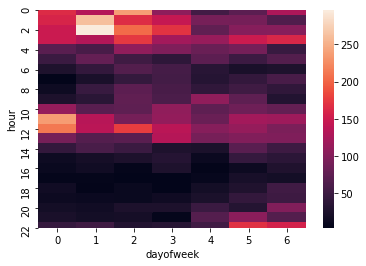

In [4]:
sns.heatmap(
    heatmap_df
        .loc[heatmap_df.is_trump, ["dayofweek", "hour", "text"]]
        .pivot("hour", "dayofweek", "text")
)

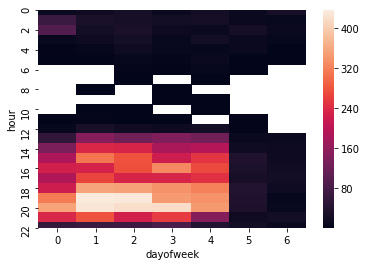

In [5]:
sns.heatmap(
    heatmap_df
        .loc[~heatmap_df.is_trump, ["dayofweek", "hour", "text"]]
        .pivot("hour", "dayofweek", "text")
)

# TFIDF Features

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_features = tfidf.fit_transform(twitter_df["text"])

tfidf_features

<25870x33952 sparse matrix of type '<class 'numpy.float64'>'
	with 268235 stored elements in Compressed Sparse Row format>

In [7]:
n_top = 20

def get_important_words(row_ind):
    trump_features = tfidf_features[row_ind]
    word_importances = np.asarray(trump_features.sum(axis=0)).reshape(-1)
    best_n = np.argsort(word_importances)[-n_top:]
    rev_vocabulary = dict((v,k) for k,v in tfidf.vocabulary_.items())
    for  i in best_n[::-1]:
        print(f"{rev_vocabulary[i]}: {word_importances[i]}")
    
print("IS_TRUMP")
get_important_words(twitter_df.is_trump.values)
print("\nNOT_TRUMP")
get_important_words(~twitter_df.is_trump.values)

IS_TRUMP
realdonaldtrump: 786.893231944307
trump: 334.8701349302388
great: 279.7227321107719
president: 272.9685912700854
thanks: 206.83351195669061
run: 185.90244778556396
donald: 179.1684461801854
twitter: 167.0370380577728
false: 158.19948067062833
thank: 149.07743300637512
just: 139.41319182190526
android: 138.2461868649911
country: 122.98792549110506
america: 120.73775775956616
love: 116.23792437032652
vote: 115.93935266756266
mr: 115.13766553758782
make: 114.03687815953624
like: 112.856193550155
people: 112.35783191790375

NOT_TRUMP
great: 253.60484580070906
thank: 237.55508066436101
thanks: 234.6837364543979
trump: 213.29518255029035
obama: 164.59112126264816
barackobama: 142.19028564600458
trump2016: 136.51739704328145
new: 133.68538920243012
makeamericagreatagain: 118.07255874682319
just: 110.32386366116718
good: 107.74848583655908
america: 107.43291235499689
donald: 103.28459701502284
people: 100.08666270970019
don: 96.31363582603817
think: 95.4730547449436
like: 93.366158063

## Text Features

(-20, 150)

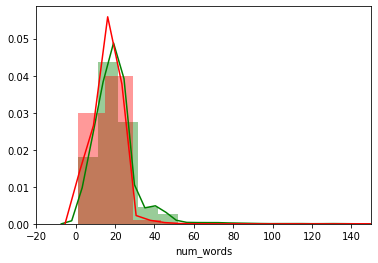

In [8]:
msg_length_df = (
    twitter_df.assign(num_words = twitter_df["text"].str.split(" ").apply(len),
                      num_chars = twitter_df["text"].apply(len),
                      num_caps = twitter_df["text"].str.replace(r"[^\w\s]", "", regex=True).str.findall(r"\s([A-Z]+)\s").apply(len))
    .filter(["is_trump", "num_words", "num_chars", "num_caps"])
)

sns.distplot(msg_length_df[msg_length_df.is_trump]["num_words"], color="g")
sns.distplot(msg_length_df[~msg_length_df.is_trump]["num_words"], color="r")
plt.xlim(-20,150)

(-20, 1000)

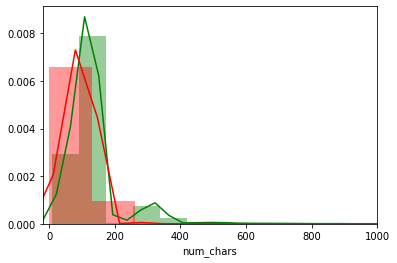

In [9]:
sns.distplot(msg_length_df[msg_length_df.is_trump]["num_chars"], color="g")
sns.distplot(msg_length_df[~msg_length_df.is_trump]["num_chars"], color="r")
plt.xlim(-20,1000)

(-1, 6)

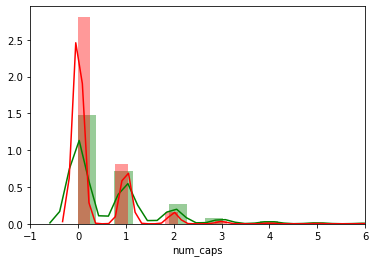

In [10]:
sns.distplot(msg_length_df[msg_length_df.is_trump]["num_caps"], color="g")
sns.distplot(msg_length_df[~msg_length_df.is_trump]["num_caps"], color="r")
plt.xlim(-1,6)